In [1]:
"""
use time to cut sequences
command 
python main_time.py --data_folder ../Data/xing/ --train_data train_item.pickle --valid_data test_item.pickle --test_data test_item.pickle --data_name xing --embedding_dim 300 --hidden_size 300 --lr 0.005
"""
import argparse
import torch
# import lib
import numpy as np
import os
import datetime
from loss import *
from network import *
from optimizer import *
from trainer import *
from torch.utils import data
import pickle
import sys
from dataset_time import *
# from data_time import *
from logger import *
import collections

import sys
sys.path.insert(0, '../PyTorch_GBW_LM')
sys.path.insert(0, '../PyTorch_GBW_LM/log_uniform')

from sampledSoftmax import *

In [2]:
import matplotlib.pyplot as plt

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--hidden_size', default=50, type=int)
parser.add_argument('--num_layers', default=1, type=int)
parser.add_argument('--batch_size', default=100, type=int)
parser.add_argument('--dropout_input', default=0, type=float)
parser.add_argument('--dropout_hidden', default=.2, type=float)

# parse the optimizer arguments
parser.add_argument('--optimizer_type', default='Adagrad', type=str)
parser.add_argument('--final_act', default='tanh', type=str)
parser.add_argument('--lr', default=.05, type=float)
parser.add_argument('--weight_decay', default=0.0, type=float)
parser.add_argument('--momentum', default=0.1, type=float)
parser.add_argument('--eps', default=1e-6, type=float)

parser.add_argument("-seed", type=int, default=7,
                     help="Seed for random initialization")
parser.add_argument("-sigma", type=float, default=None,
                     help="init weight -1: range [-sigma, sigma], -2: range [0, sigma]")
parser.add_argument("--embedding_dim", type=int, default=-1,
                     help="using embedding")
# parse the loss type
parser.add_argument('--loss_type', default='TOP1', type=str)
# parser.add_argument('--loss_type', default='BPR', type=str)
parser.add_argument('--topk', default=5, type=int)
# etc
parser.add_argument('--bptt', default=1, type=int)
parser.add_argument('--test_observed', default=5, type=int)
parser.add_argument('--window_size', default=30, type=int)
parser.add_argument('--warm_start', default=5, type=int)

parser.add_argument('--n_epochs', default=20, type=int)
parser.add_argument('--time_sort', default=False, type=bool)
parser.add_argument('--save_dir', default='models', type=str)
parser.add_argument('--data_folder', default='../Data/movielen/1m/', type=str)
parser.add_argument('--data_action', default='item.pickle', type=str)
parser.add_argument('--data_cate', default='cate.pickle', type=str)
parser.add_argument('--data_time', default='time.pickle', type=str)
parser.add_argument("--is_eval", action='store_true')
parser.add_argument('--load_model', default=None,  type=str)
parser.add_argument('--checkpoint_dir', type=str, default='checkpoint')
parser.add_argument('--data_name', default=None, type=str)
parser.add_argument('--shared_embedding', default=None, type=int)
parser.add_argument('--patience', default=1000)
parser.add_argument('--negative_num', default=1000, type=int)
parser.add_argument('--valid_start_time', default=0, type=int)
parser.add_argument('--test_start_time', default=0, type=int)
parser.add_argument('--model_name', default="samplePaddingSessionRNN", type=str)

# Get the arguments
args = parser.parse_args([])
args.cuda = torch.cuda.is_available()

In [4]:
# CUDA_VISIBLE_DEVICES=0 python eval_main_time.py --data_folder ../Data/tmall/100k_unknown_cate/ 
# --data_action item_time.pickle --data_cate cate_time.pickle --data_time time_time.pickle 
# --data_name taobao --embedding_dim 300 --hidden_size 300 --lr 0.001 --window_size 20 
# --test_observed 5 --n_epochs 100 --shared_embedding 1 --batch_size 300 
# --optimizer_type Adam --loss_type 'XE' --valid_start_time 1512172800 --test_start_time 1512259200 
# --negative_num 10000 --topk 20 --checkpoint_dir "../log/samplePaddingSessionRNN/checkpoint/01022149"


In [5]:
args.data_folder = "../../../Data/tmall/100k_unknown_cate/"
args.data_action = "item_time.pickle"
args.data_cate = "cate_time.pickle"
args.data_time = "time_time.pickle"
args.data_name = "taobao"
args.embedding_dim = 256
args.hidden_size = 256
args.lr = 0.001
args.window_size = 20
args.test_observed = 5
args.n_epochs = 100
args.shared_embedding = 1
args.batch_size = 256
args.optimizer_type = "Adam"
args.loss_type = "XE"
args.valid_start_time = 1512172800
args.test_start_time = 1512259200
args.negative_num = 10000
args.topk = 20
args.checkpoint_dir = "../../log/samplePaddingSessionRNN/checkpoint/01031151"

In [6]:
np.random.seed(args.seed)
torch.manual_seed(7)
random.seed(args.seed)

if args.cuda:
    print("gpu")
    torch.cuda.manual_seed(args.seed)
else:
    print("cpu")

gpu


In [7]:
### 
item_time_file = os.path.join(args.data_folder, args.data_action)
f = open(item_time_file, "rb")
item_time_array = pickle.load(f)
f.close()

In [8]:
seq_num = len(item_time_array)
seq_len_dist = []
total_action_num = 0
for i in range(seq_num):
    seq_len_i = len(item_time_array[i])
    
    seq_len_dist.append(seq_len_i)
    total_action_num += seq_len_i
print("total action num", total_action_num)

total action num 3785961


In [9]:
user_num = 51275
item_num = 68008
action_num = 3785961
density_ratio = action_num/(user_num*item_num)
print('density ratio', density_ratio)

density ratio 0.001085701564579175


In [10]:
import matplotlib.pyplot as plt

In [11]:
min(seq_len_dist), max(seq_len_dist)

(21, 409)

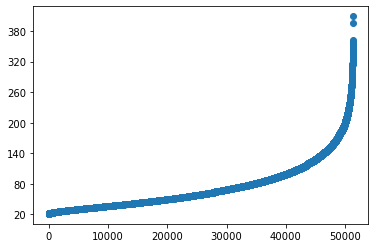

In [12]:
x = [i for i in range(seq_num)]
y = sorted(seq_len_dist)
plt.plot(x, y, "o")
plt.yticks(range(20, 420, 60))
plt.show()

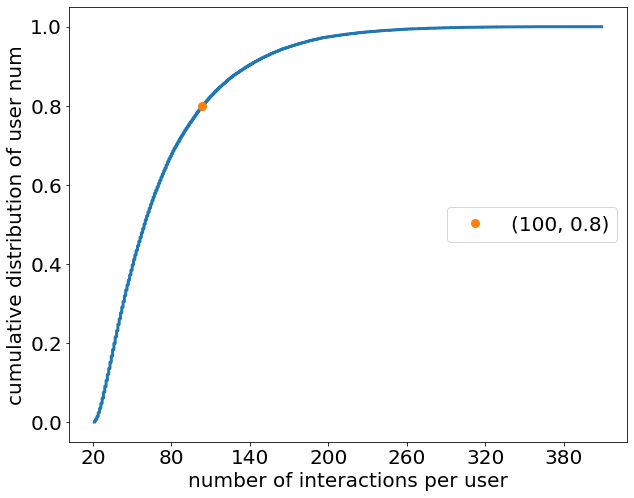

In [13]:

plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams['font.size'] = 20

cdf = 1.0*np.arange(len(y))/(len(y)-1)
plt.plot(y, cdf, linewidth=3)
plt.plot(103, 0.8, "o", label="(100, 0.8)", markersize=8)
plt.ylabel("cumulative distribution of user num")
plt.xlabel("number of interactions per user")
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xticks(range(20, 420, 60))
plt.legend(loc="right")
plt.show()

In [14]:
# 1512172800: 12/02/2017 @ 12:00am (UTC)
### 1512187200: 12/02/2017 @ 4:00am (UTC)
## 1512201600: 12/02/2017 @ 8:00am (UTC)
### 1512216000: 12/02/2017 @ 12:00pm (UTC)
### 1512230400: 12/02/2017 @ 4:00pm (UTC)
### 1512244800: 12/02/2017 @ 8:00pm (UTC)
# 1512259200: 12/03/2017 @ 12:00am (UTC)

In [15]:
def make_checkpoint_dir(log):
    print("PARAMETER" + "-"*10)
    now = datetime.datetime.now()
    S = '{:02d}{:02d}{:02d}{:02d}'.format(now.month, now.day, now.hour, now.minute)
    checkpoint_dir = "../log/"+args.model_name+"/"+args.checkpoint_dir
    args.checkpoint_dir = checkpoint_dir
    save_dir = os.path.join(args.checkpoint_dir, S)

    if not os.path.exists("../log"):
        os.mkdir("../log")
    
    if not os.path.exists("../log/"+args.model_name):
        os.mkdir("../log/"+args.model_name)

    if not os.path.exists(args.checkpoint_dir):
        os.mkdir(args.checkpoint_dir)

    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    args.checkpoint_dir = save_dir
    
    with open(os.path.join(args.checkpoint_dir, 'parameter.txt'), 'w') as f:
        for attr, value in sorted(args.__dict__.items()):
            msg = "{}={}".format(attr.upper(), value)
            log.addOutput2IO(msg)
            f.write("{}={}\n".format(attr.upper(), value))

    msg = "---------" + "-"*10
    log.addOutput2IO(msg)

def load_args(model_path):
    model_file = os.path.join(model_path, "model_best.pt")
    print("args file load", model_file)
    check_point = torch.load(model_file)
    args = check_point['args']

def load_model(network, model_path):
    print("reload model")
    model_file = os.path.join(model_path, "model_best.pt")
    print("model file", model_file)
    check_point = torch.load(model_file)

    network.load_state_dict(check_point['model'])

def count_parameters(model):
    parameter_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("parameter_num", parameter_num) 


In [16]:
model_path = args.checkpoint_dir
load_args(model_path)

BPTT = args.bptt

device = torch.device('cuda' if args.cuda else 'cpu')
print("device", device)

if args.embedding_dim == -1:
    raise AssertionError()

data_name = args.data_name

print("*"*10+"train load"+"*"*10)

observed_threshold = args.test_observed

data_action = args.data_folder+args.data_action
data_cate = args.data_folder+args.data_cate
data_time = args.data_folder+args.data_time

valid_start_time = args.valid_start_time
test_start_time = args.test_start_time

st = datetime.datetime.now()
data_obj = MYDATA(data_action, data_cate, data_time, valid_start_time, test_start_time, observed_threshold, args.window_size)
et = datetime.datetime.now()
print("load data duration ", et-st)

train_data = data_obj.train_dataset
valid_data = data_obj.test_dataset
test_data = data_obj.test_dataset

print("+"*10+"valid load"+"+"*10)

input_size = data_obj.items()
output_size = input_size

negative_num = args.negative_num

train_data_loader = MYDATALOADER(train_data, args.batch_size)
valid_data_loader = MYDATALOADER(valid_data, args.batch_size)
test_data_loader = MYDATALOADER(valid_data, args.batch_size)

ss = SampledSoftmax(output_size, negative_num, args.embedding_dim, None)

network = NETWORK(input_size, ss, args, device)
load_model(network, model_path)

### eval
loss_function = LossFunction(device, loss_type=args.loss_type)

topk = args.topk
eval = Evaluation(None, network, loss_function, device, topk, args.warm_start)

args file load ../../log/samplePaddingSessionRNN/checkpoint/01031151/model_best.pt
device cuda
**********train load**********
action seq num 51275
time seq num 51275
loading item map
loading item map
observed_threshold 5 20
loading data
valid_start_time 1512172800
test start time 1512259200
seq num for training 2738883
seq num of actions for training 2738883
seq num for testing 430797
seq num of actions for testing 430797
load data duration  0:00:09.323143
++++++++++valid load++++++++++
item num 68008
seq num 2738883
batch size 256
batch_num 10698
seq num 430797
batch size 256
batch_num 1682
seq num 430797
batch size 256
batch_num 1682


/u/sr3hd/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


reload model
model file ../../log/samplePaddingSessionRNN/checkpoint/01031151/model_best.pt


### get time id

In [17]:
# 1512172800: 12/02/2017 @ 12:00am (UTC)
### 1512187200: 12/02/2017 @ 4:00am (UTC)
## 1512201600: 12/02/2017 @ 8:00am (UTC)
### 1512216000: 12/02/2017 @ 12:00pm (UTC)
### 1512230400: 12/02/2017 @ 4:00pm (UTC)
### 1512244800: 12/02/2017 @ 8:00pm (UTC)
# 1512259200: 12/03/2017 @ 12:00am (UTC)

In [18]:
def get_timeid(time):
    time_threshold_list = [1512172800, 1512187200, 1512201600, 1512216000, 1512230400, 1512244800, 1512259200]
#     print("time threshold num", len(time_threshold_list))
    
    timeid = 0
    
    if time <= time_threshold_list[1]:
        timeid = 1
    elif time <= time_threshold_list[2]:
        timeid = 2
    elif time <= time_threshold_list[3]:
        timeid = 3
    elif time <= time_threshold_list[4]:
        timeid = 4
    elif time <= time_threshold_list[5]:
        timeid = 5
    else:
        timeid = 6
        
    return timeid

In [19]:
# time_item_freq_dict = {}
# time_bucket_recall_dict = {}
# time_bucket_mrr_dict = {}

In [20]:
def bias_eval(eval_data):
    network.eval()

    losses = []
    recalls = []
    mrrs = []
    weights = []

    dataloader = eval_data
    topk = args.topk
    
    ### time: item: [recall]
    time_item_recall_dict = {}
    time_item_mrr_dict = {}

    
### t_y_batch: time of y action
    
    with torch.no_grad():
        total_test_num = []

        for x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch, \
        y_action_batch, y_action_idx_batch, t_y_batch in dataloader:
            
            x_short_action_batch = x_short_action_batch.to(device)
            mask_short_action_batch = mask_short_action_batch.to(device)
            y_action_batch = y_action_batch.to(device)

            # warm_start_mask = (y_action_idx_batch>=self.warm_start)

            output_batch = network(x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch)

            sampled_logit_batch, sampled_target_batch = network.m_ss(output_batch, y_action_batch, \
                                                        None, None, None, None, None, None, "full")

            loss_batch = loss_function(sampled_logit_batch, sampled_target_batch)
            losses.append(loss_batch.item())

            _, preds = torch.topk(sampled_logit_batch, topk, -1)
            preds = preds.cpu()
            targets = sampled_target_batch.cpu()

            expand_targets = targets.view(-1, 1).expand_as(preds)
            hits = (preds == expand_targets)

            for i, hit in enumerate(hits):
                target_i = targets[i]
                itemid_i = target_i.item()
                time_i = t_y_batch[i].item()
                timeid = get_timeid(time_i)
                
                if timeid not in time_item_recall_dict:
                    time_item_recall_dict[timeid] = {}
                    time_item_mrr_dict[timeid] = {}
                if itemid_i not in time_item_recall_dict[timeid]:
                    time_item_recall_dict[timeid][itemid_i] = []
                    time_item_mrr_dict[timeid][itemid_i] = []
                
                rank = hit.nonzero()
                
                if len(rank) == 1:
                    time_item_recall_dict[timeid][itemid_i].append(1.0)
                    rank = rank[0]+1.0
                    rank = torch.reciprocal(rank.float())
                    time_item_mrr_dict[timeid][itemid_i].append(rank.item())
                else:
                    time_item_recall_dict[timeid][itemid_i].append(0.0)
                    time_item_mrr_dict[timeid][itemid_i].append(0.0)
                
            total_test_num.append(y_action_batch.view(-1).size(0))
            
    return time_item_recall_dict, time_item_mrr_dict
    

In [21]:
def get_time_item_freq(eval_data, time_item_freq_dict):
    network.eval()

    losses = []
    recalls = []
    mrrs = []
    weights = []

    dataloader = eval_data
    topk = args.topk
    
    ### time: item: freq
    
    ### t_action_batch: time of y action
    
    with torch.no_grad():
        total_test_num = []

        for x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch, \
        y_action_batch, y_action_idx_batch, t_y_batch in dataloader:
            batch_size = y_action_batch.size(0)
            for seq_index in range(batch_size):
                y_i = y_action_batch[seq_index]
                t_i = t_y_batch[seq_index]
                item_i = y_i.item()
                time_id = get_timeid(t_i.item())
                
                if time_id not in time_item_freq_dict:
                    time_item_freq_dict[time_id] = {}
                if item_i not in time_item_freq_dict[time_id]:
                    time_item_freq_dict[time_id][item_i] = 0.0
                time_item_freq_dict[time_id][item_i] += 1.0
#     return time_item_freq_dict

In [22]:
def get_item_freq(eval_data, item_freq_dict):
    network.eval()

    losses = []
    recalls = []
    mrrs = []
    weights = []

    dataloader = eval_data
    topk = args.topk
    
    ### time: item: freq
    
    ### t_action_batch: time of y action
    
    with torch.no_grad():
        total_test_num = []

        for x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch, \
        y_action_batch, y_action_idx_batch, t_y_batch in dataloader:
            batch_size = y_action_batch.size(0)
            for seq_index in range(batch_size):
                y_i = y_action_batch[seq_index]
                t_i = t_y_batch[seq_index]
                item_i = y_i.item()
                
                if item_i not in item_freq_dict:
                    item_freq_dict[item_i] = 0.0
                item_freq_dict[item_i] += 1.0

In [23]:
def load_train_freq(time_item_freq_dict, item_freq_dict):
    for time in time_item_freq_dict:
        item_freq_dict_time = time_item_freq_dict[time]
        
        for item in item_freq_dict:
            if item not in item_freq_dict_time:
                item_freq_dict_time[item] = 0.0
            item_freq_dict_time[item] += item_freq_dict[item]
    
    time_item_freq_dict[0] = {}
    for item in item_freq_dict:
        time_item_freq_dict[0][item] = item_freq_dict[item]
        

In [24]:
train_item_freq_dict = {}
get_item_freq(train_data_loader, train_item_freq_dict)

shuffling


In [25]:
time_item_freq_dict = {}
get_time_item_freq(test_data_loader, time_item_freq_dict)

shuffling


In [26]:
load_train_freq(time_item_freq_dict, train_item_freq_dict)

In [27]:
def set_bucket4item(time_item_freq_dict):
#     item_freq_dict = dict(Counter(data.m_y_action))
#     print(len(item_freq_dict))
#     freq_list = list(item_freq_dict.values())
#     print(min(freq_list), max(freq_list))
#     freq_threshold_list = [0, 20, 80, 150, 200, 250, 300, 350]
    
    ### set bucket for each item in a time period
    
    time_itemid_bucketid_dict = {}
    time_bucketid_itemidlist_dict = {}
    time_bucket_freq_dict = {}
    
    sorted_time_list = sorted(list(time_item_freq_dict.keys()))
    for time in sorted_time_list:
        print("=="*10+str(time)+"=="*10)
        if time not in time_itemid_bucketid_dict:
            time_itemid_bucketid_dict[time] = {}
        if time not in time_bucketid_itemidlist_dict:
            time_bucketid_itemidlist_dict[time] = {}
        
        bucket_freq_dict_time = set_bucket4item_time(time_item_freq_dict[time], time_itemid_bucketid_dict[time], time_bucketid_itemidlist_dict[time])
        
        time_bucket_freq_dict[time] = bucket_freq_dict_time
                
    return time_itemid_bucketid_dict, time_bucketid_itemidlist_dict, time_bucket_freq_dict

In [28]:
def set_bucket4item_time(item_freq_dict_time, itemid_bucketid_dict_time, bucketid_itemidlist_dict_time):
    freq_threshold_list = [0, 20, 30, 40, 80, 120, 240, 400]
    bucket_freq_dict_time = {}
    for itemid in item_freq_dict_time:
        i = item_freq_dict_time[itemid]
        bucketid = 0
        if i <= freq_threshold_list[1]:
            bucketid = 1
        elif i <= freq_threshold_list[2]:
            bucketid = 2
        elif i <= freq_threshold_list[3]:
            bucketid = 3
        elif i <= freq_threshold_list[4]:
            bucketid = 4
        elif i <= freq_threshold_list[5]:
            bucketid = 5
        elif i <= freq_threshold_list[6]:
            bucketid = 6
        elif i <= freq_threshold_list[7]:
            bucketid = 7
        else:
            bucketid = 8
            
        itemid_bucketid_dict_time[itemid] = bucketid
        if bucketid not in bucketid_itemidlist_dict_time:
            bucketid_itemidlist_dict_time[bucketid] = []
        bucketid_itemidlist_dict_time[bucketid].append(itemid)
        
    print("bucket", len(bucketid_itemidlist_dict_time), bucketid_itemidlist_dict_time.keys())
#     for bucketid in bucketid_itemidlist_dict:
    for bucketid in range(1, len(bucketid_itemidlist_dict_time)+1):
        itemid_list_bucket = bucketid_itemidlist_dict_time[bucketid]
        freq_bucket = 0
        for itemid in itemid_list_bucket:
            freq_bucket += item_freq_dict_time[itemid]
        bucket_freq_dict_time[bucketid] = freq_bucket
        print("bucket %d, freq: %d, item num: %d"%(bucketid, freq_bucket, len(itemid_list_bucket)))
#     print("++"*20)
    return bucket_freq_dict_time

In [29]:
# time_item_freq_dict = {}
# get_time_item_freq(train_data_loader, time_item_freq_dict)

In [30]:
# get_time_item_freq(test_data_loader, time_item_freq_dict)

In [31]:
time_item_freq_dict.keys()

dict_keys([2, 1, 5, 4, 3, 6, 0])

In [32]:
time_itemid_bucketid_dict, time_bucketid_itemidlist_dict, time_bucket_freq_dict = set_bucket4item(time_item_freq_dict)

====================0====================
bucket 8 dict_keys([7, 2, 1, 5, 3, 4, 6, 8])
bucket 1, freq: 347360, item num: 21237
bucket 2, freq: 476991, item num: 19241
bucket 3, freq: 323545, item num: 9261
bucket 4, freq: 676329, item num: 12280
bucket 5, freq: 311280, item num: 3198
bucket 6, freq: 343391, item num: 2116
bucket 7, freq: 143984, item num: 482
bucket 8, freq: 115808, item num: 191
====================1====================
bucket 8 dict_keys([2, 4, 1, 6, 7, 3, 5, 8])
bucket 1, freq: 322607, item num: 19642
bucket 2, freq: 490533, item num: 19775
bucket 3, freq: 334497, item num: 9569
bucket 4, freq: 704058, item num: 12764
bucket 5, freq: 321419, item num: 3297
bucket 6, freq: 362327, item num: 2240
bucket 7, freq: 152573, item num: 512
bucket 8, freq: 125242, item num: 207
====================2====================
bucket 8 dict_keys([2, 8, 4, 6, 1, 5, 3, 7])
bucket 1, freq: 320582, item num: 19484
bucket 2, freq: 490863, item num: 19792
bucket 3, freq: 337623, item num:

In [33]:
sorted_time_list = sorted(list(time_bucket_freq_dict.keys()))
base_bucket_freq_dict = time_bucket_freq_dict[sorted_time_list[0]]
for time in sorted_time_list[1:]:
    bucket_freq_dict_time = time_bucket_freq_dict[time]
    sorted_bucket_list = sorted(list(bucket_freq_dict_time.keys()))
    print("=="*10+"time "+str(time)+"=="*10)
    for bucket in sorted_bucket_list:
        freq = bucket_freq_dict_time[bucket]
        
        base_freq = base_bucket_freq_dict[bucket]
        diff_freq = freq-base_freq
        print("bucket:%d, base freq:%d, freq:%d, diff:%d"%(bucket, base_freq, freq, diff_freq))

====================time 1====================
bucket:1, base freq:347360, freq:322607, diff:-24753
bucket:2, base freq:476991, freq:490533, diff:13542
bucket:3, base freq:323545, freq:334497, diff:10952
bucket:4, base freq:676329, freq:704058, diff:27729
bucket:5, base freq:311280, freq:321419, diff:10139
bucket:6, base freq:343391, freq:362327, diff:18936
bucket:7, base freq:143984, freq:152573, diff:8589
bucket:8, base freq:115808, freq:125242, diff:9434
====================time 2====================
bucket:1, base freq:347360, freq:320582, diff:-26778
bucket:2, base freq:476991, freq:490863, diff:13872
bucket:3, base freq:323545, freq:337623, diff:14078
bucket:4, base freq:676329, freq:707299, diff:30970
bucket:5, base freq:311280, freq:322943, diff:11663
bucket:6, base freq:343391, freq:362850, diff:19459
bucket:7, base freq:143984, freq:152609, diff:8625
bucket:8, base freq:115808, freq:127003, diff:11195
====================time 3====================
bucket:1, base freq:347360, 

### get bucket for train data

In [34]:
# def set_bucket4item_train(item_freq_dict, itemid_bucketid_dict, bucketid_itemidlist_dict):
#     freq_threshold_list = [0, 20, 30, 40, 80, 120, 240, 400]
#     for itemid in item_freq_dict:
#         i = item_freq_dict[itemid]
#         bucketid = 0
#         if i <= freq_threshold_list[1]:
#             bucketid = 1
#         elif i <= freq_threshold_list[2]:
#             bucketid = 2
#         elif i <= freq_threshold_list[3]:
#             bucketid = 3
#         elif i <= freq_threshold_list[4]:
#             bucketid = 4
#         elif i <= freq_threshold_list[5]:
#             bucketid = 5
#         elif i <= freq_threshold_list[6]:
#             bucketid = 6
#         elif i <= freq_threshold_list[7]:
#             bucketid = 7
#         else:
#             bucketid = 8
            
#         itemid_bucketid_dict[itemid] = bucketid
#         if bucketid not in bucketid_itemidlist_dict:
#             bucketid_itemidlist_dict[bucketid] = []
#         bucketid_itemidlist_dict[bucketid].append(itemid)
        
#     print("bucket", len(bucketid_itemidlist_dict), bucketid_itemidlist_dict.keys())
# #     for bucketid in bucketid_itemidlist_dict:
#     for bucketid in range(1, len(bucketid_itemidlist_dict)+1):
#         itemid_list_bucket = bucketid_itemidlist_dict[bucketid]
#         freq_bucket = 0
#         for itemid in itemid_list_bucket:
#             freq_bucket += item_freq_dict[itemid]
#         print("bucket %d, freq: %d, item num: %d"%(bucketid, freq_bucket, len(itemid_list_bucket)))
#     print("==="*20)

In [35]:
train_itemid_bucketid_dict = {}
train_bucketid_itemidlist_dict = {}
set_bucket4item_train(train_item_freq_dict, train_itemid_bucketid_dict, train_bucketid_itemidlist_dict)

NameError: name 'set_bucket4item_train' is not defined

In [36]:
time_item_recall_dict, time_item_mrr_dict = bias_eval(valid_data_loader)

shuffling


<ipython-input-20-116ab9026deb>:59: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370117127/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  rank = hit.nonzero()


In [37]:
# time_item_freq_dict = {}
# time_bucket_recall_dict = {}
# time_bucket_mrr_dict = {}

In [38]:
time_bucket_recall_dict = {}
time_bucket_mrr_dict = {}
for time in time_item_recall_dict:
    item_freq_dict_time = time_item_freq_dict[time]
    item_recall_dict_time = time_item_recall_dict[time]
    item_mrr_dict_time = time_item_mrr_dict[time]
    itemid_bucketid_dict_time = time_itemid_bucketid_dict[time]
    bucketid_itemidlist_dict_time = time_bucketid_itemidlist_dict[time]
    
    if time not in time_bucket_recall_dict:
        time_bucket_recall_dict[time] = {}
        time_bucket_mrr_dict[time] = {}
    
    for item in item_recall_dict_time:
        bucketid = itemid_bucketid_dict_time[item]
        item_recall = np.mean(item_recall_dict_time[item])

        if bucketid not in time_bucket_recall_dict[time]:
            time_bucket_recall_dict[time][bucketid] = []
            time_bucket_mrr_dict[time][bucketid] = []
            
        time_bucket_recall_dict[time][bucketid].append(item_recall)

        item_mrr = np.mean(item_mrr_dict_time[item])
        time_bucket_mrr_dict[time][bucketid].append(item_mrr)

    for bucket in time_bucket_recall_dict[time]:
        recall_list = time_bucket_recall_dict[time][bucket]
        mean_recall = np.mean(recall_list)
        time_bucket_recall_dict[time][bucket] = mean_recall

    for bucket in time_bucket_mrr_dict[time]:
        mrr_list = time_bucket_mrr_dict[time][bucket]
        mean_mrr = np.mean(mrr_list)
        time_bucket_mrr_dict[time][bucket] = mean_mrr  

In [45]:
print("**"*10+"recall"+"**"*10)
for time in range(1, 7):
    if time not in time_bucket_recall_dict:
        continue
    
    print("--"*15+"time "+str(time)+"--"*15)
    for k in range(1, 9):
        if k not in time_bucket_recall_dict[time]:
            continue
        recall = time_bucket_recall_dict[time][k]
        print("%d:%.4f"%(k, recall), end=", ")
    print()

print("**"*10+"mrr"+"**"*10)
for time in range(1, 7):
    if time not in time_bucket_mrr_dict:
        continue
    print("--"*15+"time "+str(time)+"--"*15)
    for k in range(1, 9):
        if k not in time_bucket_mrr_dict[time]:
            continue
        mrr = time_bucket_mrr_dict[time][k]
        print("%d:%.4f"%(k, mrr), end=", ")
    print()

********************recall********************
------------------------------time 1------------------------------
1:0.1183, 2:0.1404, 3:0.1565, 4:0.1676, 5:0.1890, 6:0.2161, 7:0.2188, 8:0.2653, 
------------------------------time 2------------------------------
1:0.1045, 2:0.1339, 3:0.1547, 4:0.1681, 5:0.1931, 6:0.2119, 7:0.2478, 8:0.3033, 
------------------------------time 3------------------------------
1:0.1008, 2:0.1259, 3:0.1429, 4:0.1538, 5:0.1764, 6:0.2062, 7:0.2539, 8:0.2947, 
------------------------------time 4------------------------------
1:0.0885, 2:0.1188, 3:0.1290, 4:0.1561, 5:0.1799, 6:0.2105, 7:0.2458, 8:0.2943, 
------------------------------time 5------------------------------
1:0.0882, 2:0.1086, 3:0.1262, 4:0.1366, 5:0.1479, 6:0.1867, 7:0.2289, 8:0.2926, 
------------------------------time 6------------------------------
1:0.0939, 2:0.1097, 3:0.1219, 4:0.1290, 5:0.1440, 6:0.1904, 7:0.2102, 8:0.2728, 
********************mrr********************
---------------------

In [40]:
sorted_train_item_freq_dict = {k:v for k, v in sorted(train_item_freq_dict.items(), key=lambda x: x[1], reverse=True)}

In [41]:
sorted_itemid_list = list(sorted_train_item_freq_dict.keys())

In [42]:
sorted_train_item_freq_dict[591]

245.0

In [46]:
print("--"*10+"eval train"+"--"*10)
mean_loss, mean_recall, mean_mrr = eval.eval(train_data_loader, "train")
msg = "train loss: {:.4f}, recall: {:.4f}, mrr: {:.4f}".format(mean_loss, mean_recall, mean_mrr)
print(msg)

--------------------eval train--------------------
shuffling
train loss: 7.2489, recall: 0.3560, mrr: 0.1473


In [ ]:
# def get_bucketid(itemid, itemid_bucketid_dict):
    
#     return itemid_bucketid_dict[itemid]

In [ ]:
# bias_eval(train_data_loader, train_item_freq_dict)

In [ ]:
item_recall_dict, item_mrr_dict = bias_eval(train_data_loader, train_itemid_bucketid_dict)

In [ ]:
sorted_bucket_recall_dict = {k:v for k, v in sorted(bucket_recall_dict.items(), key=lambda x: x[0], reverse=True)}
sorted_bucket_mrr_dict = {k:v for k, v in sorted(bucket_mrr_dict.items(), key=lambda x: x[0], reverse=True)}

In [ ]:
for k in sorted_bucket_recall_dict:
#     print(k)
    recall = sorted_bucket_recall_dict[k]
    print("%d:%.4f"%(k, recall), end=", ")
print()

In [44]:
for i in range(1, 9):
    print("%d:%.4f"%(i, bucket_recall_dict[i]), end=", ")
print()

NameError: name 'bucket_recall_dict' is not defined

In [ ]:
for i in range(1, 9):
    print("%d:%.4f"%(i, bucket_mrr_dict[i]), end=", ")
print()

In [ ]:
print("recall")
train_recall_list = []
bucketid_list = []
for k in bucket_recall_dict:
    
    recall = bucket_recall_dict[k]
    print(k, "recall", recall)
    if recall[1] == 
        continue
        
    
    recall = recall[0]/recall[1]
    print("%.d:%.4f"%(k, recall), end=", ")
    
    bucketid_list.append(k)
    train_recall_list.append(recall)
print()


print("mrr")
train_mrr_list = []
for k in bucket_mrr_dict:
    mrr = bucket_mrr_dict[k]
    print(k, "mrr", mrr)
    if mrr[1] == 0:
        continue
    
    mrr = mrr[0]/mrr[1]
    print("%.d:%.4f"%(k, mrr), end=", ")
    
    train_mrr_list.append(mrr)
print()

In [ ]:
# train_recall_list = [0.1870, 0.2044, 0.2074, 0.2160, 0.2199, 0.2239, 0.2347, 0.2844]
# train_mrr_list = [0.1052, 0.1161, 0.1160, 0.1196, 0.1183, 0.1148, 0.1142, 0.1153]
# freq_list = [i for i in range(8)]